In this notebook, I'm going to attempt to build a neural network from scratch, without using pytorch or tensorflow. This entire project is an attempt for me to better understand how neural networks function underneath the hood. 

This project is heavily inspired by these two videos:

1. https://www.youtube.com/watch?v=cAkMcPfY_Ns
2. https://www.youtube.com/watch?v=w8yWXqWQYmU

This is going to be a very simple model. I'm using the MNIST database to train this network on handwritten variations of numbers, and identifying them correctly (hopefully)
This is going to be a simple network with basically 3 layers, an input layer and 2 hidden layers leading to an output. The first hidden layer will be a ReLU function and the second layer will implement a simple a softmax activation function (similar to the first link).

In the future, I want to add more layers to this network and see how it behaves and fluctuates. Currently, it achieves aproximately 95% confidence with around 92% accuracy.

UPDATE: Funny enough, I tried adding more layers, and it actually got worse. Either the layers I added were not complementing each other or I added too many layers of complexity. I might try training it with different combinations of 2 layers instead of adding multiple next and see how it behaves.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [2]:
# Reading the data
test_data = pd.read_csv('data/test.csv') 
train_data = pd.read_csv('data/train.csv')

In [26]:
# Converting into numpy array
data_numpy = np.array(train_data)
m, n = data_numpy.shape

# Separate features and labels
X = data_numpy[:, 1:n]  # Features
Y = data_numpy[:, 0]    # Labels

# Normalize features
X = X / 255.

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Transpose to match expected shape (feature dimension, number of examples)
X_train, X_test = X_train.T, X_test.T
Y_train, Y_test = Y_train.reshape(1, -1), Y_test.reshape(1, -1)

# Shapes of training and test sets
_, m_train = X_train.shape
_, m_test = X_test.shape

In [27]:
X_train.shape

(784, 33600)

In [28]:
X_test.shape

(784, 8400)

In [29]:
Y_train

array([[6, 5, 3, ..., 2, 6, 0]], dtype=int64)

In [14]:
# Now this is the real stuff, moving onto the fundamentals of the network

# Parameters for the back propogation
def init_params():
    W1 = np.random.rand(10, 784) - 0.5  # Input layer weight matrix for hidden layer
    b1 = np.random.rand(10, 1) - 0.5    # Bias for hidden layer
    W2 = np.random.rand(10, 10) - 0.5   # Weight matrix for output layer
    b2 = np.random.rand(10, 1) - 0.5    # Bias for output layer
    return W1, b1, W2, b2

# Rectified Linear Unit
def ReLU(x):
    return x * (x > 0)

def deriv_ReLU(Y):
    return Y > 0

# Softmax activation function
def softmax(x):
    sum_exp = sum(np.exp(x))
    softmax = np.exp(x) / sum_exp
    return softmax

# Tanh function
def tanh(x):
    return (2 / (1 + np.exp(-2 * np.clip(x, -100, 100)))) - 1

# Derivative of Tanh function
def deriv_tanh(Y):
    return 1 - np.clip(Y, -100, 100)**2

# Encodes scores into 0s or 1s
def encode_answers(x):
    enc = np.zeros((x.size, x.max() + 1))
    enc[np.arange(x.size), x] = 1
    enc = enc.T
    return enc

def forward(W1, b1, W2, b2, x):
    Z1 = W1.dot(x) + b1       # Hidden layer linear transformation
    A1 = ReLU(Z1)             # Hidden layer activation with tanh
    Z2 = W2.dot(A1) + b2      # Output layer linear transformation
    A2 = softmax(Z2)          # Output layer activation with softmax
    return Z1, A1, Z2, A2

def backward(Z1, A1, A2, W2, x, Y):
    encoding = encode_answers(Y)
    m = Y.size                                # Number of training examples
    
    # Output layer gradients
    dZ2 = A2 - encoding                       # Prediction - Real answer
    dW2 = 1 / m * dZ2.dot(A1.T)               # Gradient for W2
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)  # Gradient for b2

    # Hidden layer gradients
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)      # Backprop through tanh in hidden layer
    dW1 = 1 / m * dZ1.dot(x.T)                # Gradient for W1
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)  # Gradient for b1

    return dW1, db1, dW2, db2

# Updating weights and biases for a 2-layer neural network
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    return W1, b1, W2, b2


In [15]:
def calculate_confidence(Pred, Expect):
    return (np.sum(np.argmax(Pred, 0) == Expect)/Expect.size)

def gradient_descent(X, Y, epochs, lr = 0.42):
    W1, b1, W2, b2 = init_params()
    for i in range(epochs):
        Z1, A1, Z2, A2 = forward(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward(Z1, A1, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        if i % 10 == 0:
            print(f"Epoch: {i + 1}")
            print(f"Confidence: {calculate_confidence(A2, Y)}")

    return W1, b1, W2, b2


In [52]:
W1, b1, W2, b2= gradient_descent(X_train, Y_train, 20000, 0.1)

Epoch: 1
Confidence: 0.09973214285714285
Epoch: 11
Confidence: 0.2362202380952381
Epoch: 21
Confidence: 0.30029761904761904
Epoch: 31
Confidence: 0.3855654761904762
Epoch: 41
Confidence: 0.45732142857142855
Epoch: 51
Confidence: 0.5108928571428571
Epoch: 61
Confidence: 0.5526488095238096
Epoch: 71
Confidence: 0.5927976190476191
Epoch: 81
Confidence: 0.6240178571428572
Epoch: 91
Confidence: 0.6484821428571429
Epoch: 101
Confidence: 0.6696428571428571
Epoch: 111
Confidence: 0.6867559523809523
Epoch: 121
Confidence: 0.7005654761904762
Epoch: 131
Confidence: 0.7130952380952381
Epoch: 141
Confidence: 0.7245833333333334
Epoch: 151
Confidence: 0.7348809523809524
Epoch: 161
Confidence: 0.7442559523809524
Epoch: 171
Confidence: 0.7527083333333333
Epoch: 181
Confidence: 0.7597916666666666
Epoch: 191
Confidence: 0.7656547619047619
Epoch: 201
Confidence: 0.7725595238095239
Epoch: 211
Confidence: 0.7780357142857143
Epoch: 221
Confidence: 0.7839583333333333
Epoch: 231
Confidence: 0.7881547619047619


In [43]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward(W1, b1, W2, b2, X)    # A2 is our output layer
    predictions = np.argmax(A2, 0)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_test[:, index, None]     # Printing out the images
    prediction = make_predictions(X_test[:, index, None], W1, b1, W2, b2)
    label = Y_test[0][index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [4]
Label:  4


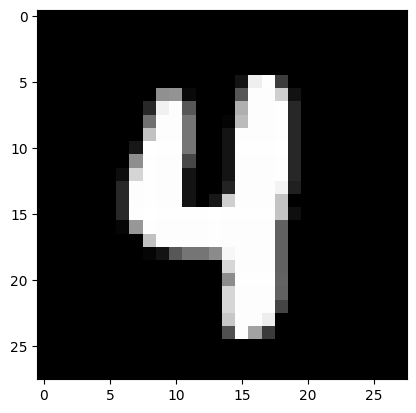

Prediction:  [4]
Label:  4


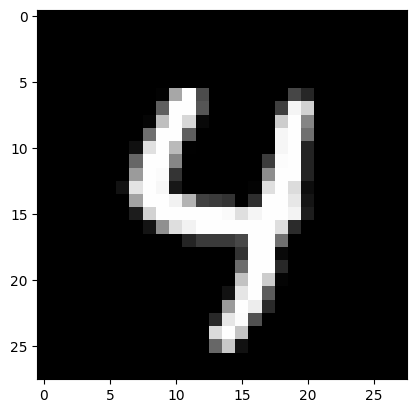

Prediction:  [4]
Label:  7


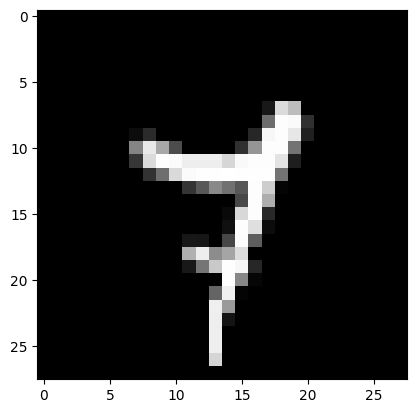

Prediction:  [9]
Label:  9


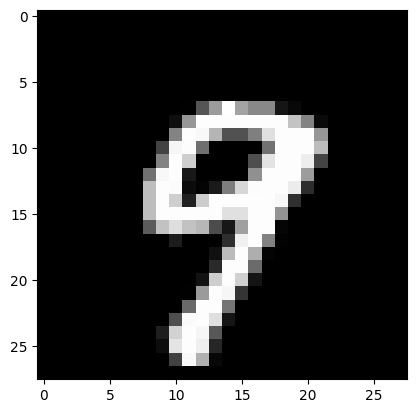

Prediction:  [2]
Label:  2


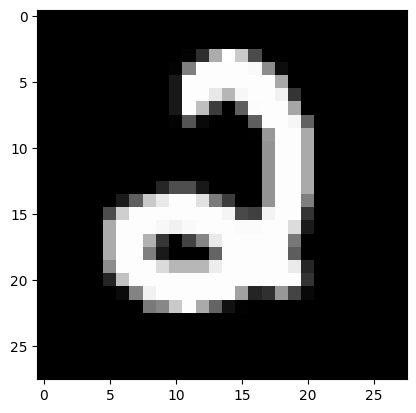

In [55]:
for _ in range(5):
    rand = random.randint(0, m_test - 1)
    test_prediction(rand, W1, b1, W2, b2)

Voila! Seems to be making decent predictions!

In [56]:
# Calculate overall model accuracy
total = m_test  
corrects = 0    

# Iterate over each test example
for i in range(total):
    prediction = make_predictions(X_test[:, i, None], W1, b1, W2, b2)
    
    if prediction == Y_test[0][i]:  
        corrects += 1  

# Print overall accuracy
print(f"Overall accuracy: {corrects / total:.4f}")  


Overall accuracy: 0.9271
